In [15]:
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from wremnants.datasets.datagroups import datagroups2016
from wremnants import plotTools
import lz4.frame
import pickle
hep.style.use(hep.style.ROOT)

In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
with lz4.frame.open("../../mw_with_mu_eta_pt.pkl.lz4") as f:
    boost = pickle.load(f)

In [18]:
groups = datagroups2016("../mw_with_mu_eta_pt.pkl.lz4")

In [20]:
histInfo = groups.datagroupsForHist("", syst="nominal", selectSignal=True, label="nominal")

In [21]:
histInfo["Data"]

dict_keys(['dataPostVFP', 'WplusmunuPostVFP', 'WminusmunuPostVFP', 'WplustaunuPostVFP', 'WminustaunuPostVFP', 'ZmumuPostVFP', 'ZtautauPostVFP', 'TTLeptonicPostVFP', 'TTSemileptonicPostVFP', 'WWPostVFP'])

In [ ]:
prednames = [x for x in histInfo.keys() if x != "Data"]
prednames

In [22]:
fig = plotTools.makeStackPlotWithRatio("unrolled", histInfo, prednames, label="nominal", unstacked="Data", xlabel=r"p$_{T}$ (GeV)", scale=2e5,rrange=[0.95, 1.05])


In [ ]:
etafig = plotTools.makePlotWithRatio("eta", histInfo, prednames, "Data", scale=1.2e7, xlabel=r"$\eta$", rrange=[0.95, 1.05], action=lambda x: x[0])

In [23]:
#data

In [ ]:
res = groups.resultsDict()

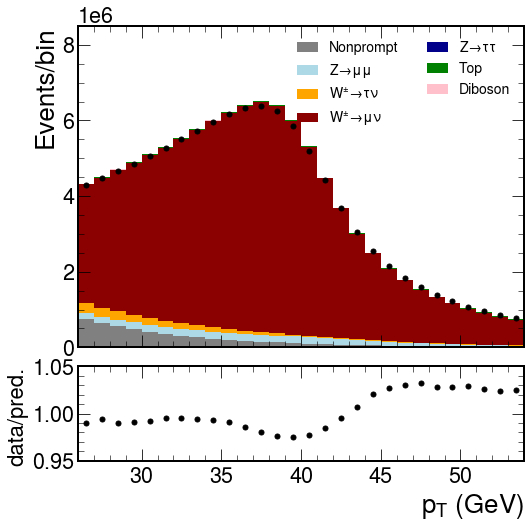

In [ ]:
res["WminusmunuPostVFP"]["output"]["muonScaleSyst"]

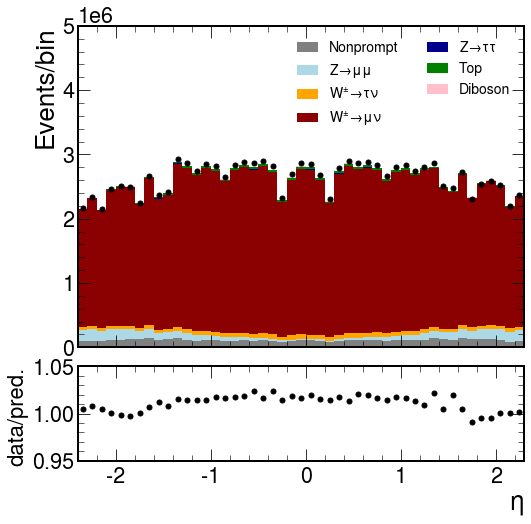

In [26]:
histInfoSyst = groups.datagroupsForHist("muonScaleSyst", selectSignal=True)

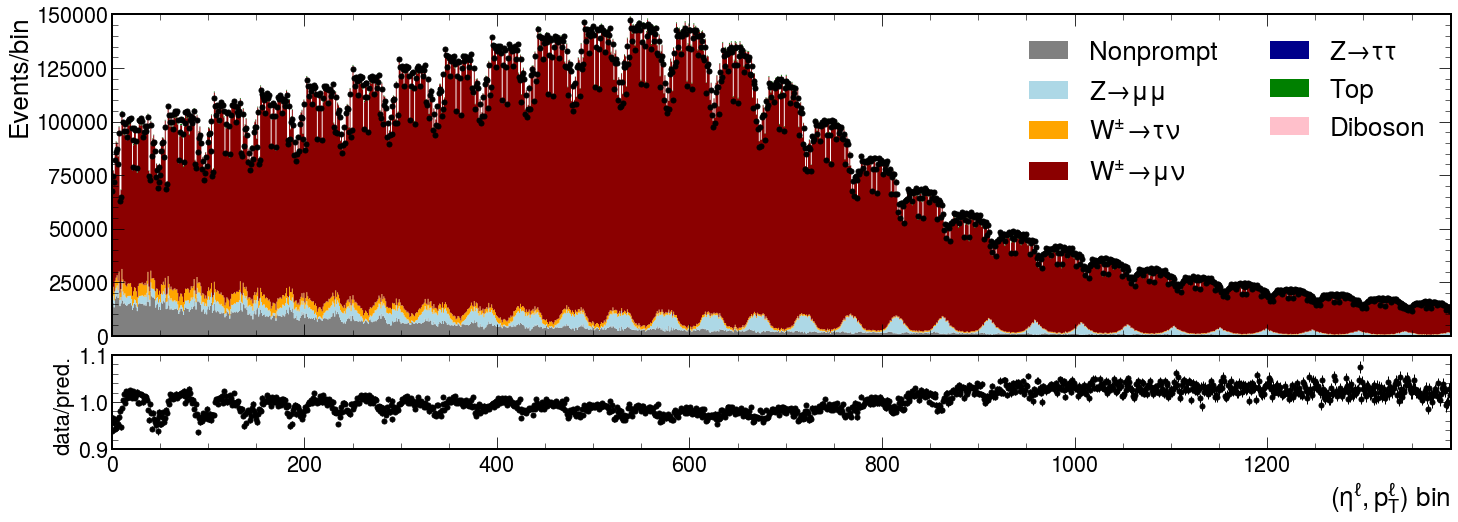

In [27]:
results = groups.resultsDict()
'muonScaleSyst' in results["WplusmunuPostVFP"]["output"]